In [1]:
!pip -q install datasets transformers

In [1]:
import os

import sklearn
import sklearn.dummy
import datasets
import torch

from huggingface_hub import notebook_login

from transformers import DistilBertTokenizer
from transformers import DistilBertModel
from transformers import AutoModelForSequenceClassification

from nlphub import vizual

# extract last hidden state and use this data as features
from nlphub import hidden_state

%load_ext autoreload
%autoreload 2

In [2]:
print("Login to Hugging Face Hub:")
notebook_login()

Login to Hugging Face Hub:


No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

OK. Load DATA : emotion
OK. Loaded TOKENIZER : <class 'transformers.models.distilbert.tokenization_distilbert.DistilBertTokenizer'>


Loading cached processed dataset at /home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-5f8cab1121c1edc1.arrow
Loading cached processed dataset at /home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-7e9af1d6b1e26fb3.arrow
Loading cached processed dataset at /home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-e344a69ef9b5a29d.arrow


OK. DATA is encoded by TOKENIZER
OK. Loaded DEVICE : cpu


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/nikitakapitan/GitHub/venvai/lib/python3.10/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.s

OK. Loaded MODEL (for hidden state) : <class 'transformers.models.distilbert.modeling_distilbert.DistilBertModel'>
(Optional) : HIDDEN_STATE as Features analysis...


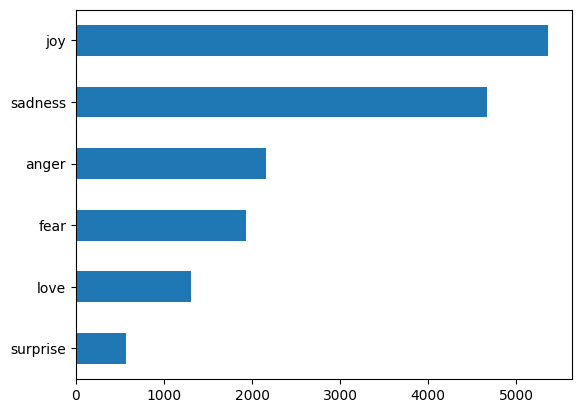

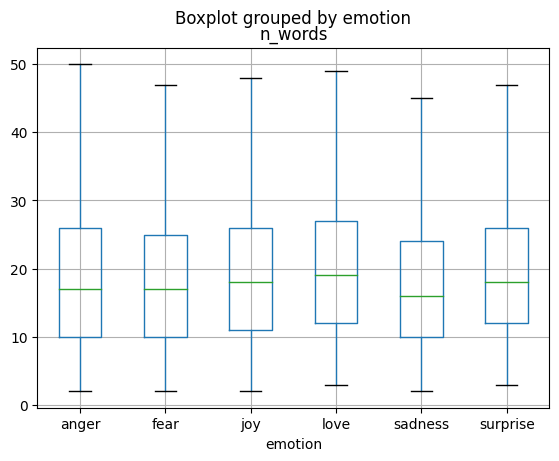

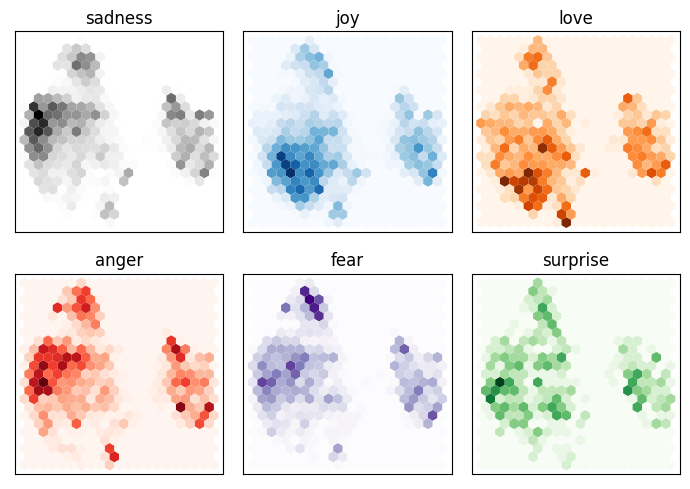

Dummy [Most Frequent] Classifier score: 0.352
LogReg trained on last hidden state score: 0.634


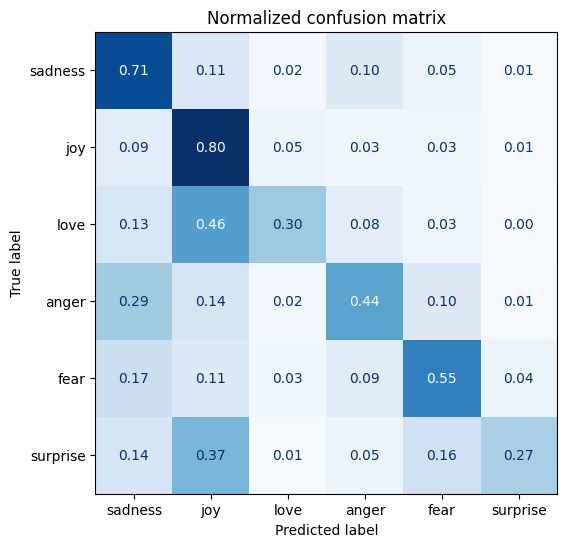

CLASSIFICATION with BERT...
Load MODEL_FOR_CLASSIFICATION


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [31]:
VIZUAL = True
HIDDEN_STATE_AS_FEATURES = True
CHECKPOINT = 'distilbert-base-uncased'


emos = datasets.load_dataset('emotion')
print('OK. Load DATA :', emos['train'].builder_name)

VIZUAL and vizual.output_distribution(dataset=emos)


tokenizer = DistilBertTokenizer.from_pretrained(CHECKPOINT)
tokenize = lambda batch : tokenizer(batch['text'], padding=True)
print('OK. Loaded TOKENIZER :', type(tokenizer))


emos_encoded = emos.map(tokenize, batched=True, batch_size=None)
print('OK. DATA is encoded by TOKENIZER')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print('OK. Loaded DEVICE :', device.type)


model = DistilBertModel.from_pretrained(CHECKPOINT)
print('OK. Loaded MODEL (for feature extraction) :', type(model))

print('(Optional) : HIDDEN_STATE as Features analysis...')
if HIDDEN_STATE_AS_FEATURES:
    
    if os.path.exists('emos_hidden'):
        emos_hidden = datasets.load_from_disk('emos_hidden') 
    else:
        print(f'Getting Hidden_state for {len(emos_encoded)} examples')
        hidden_state.get_hidden_state(data_encoded=emos_encoded, model=model, tokenizer=tokenizer, device=device)

    labels = emos_hidden["train"].features["label"].names
    X_train, X_valid, y_train, y_valid = hidden_state.prepare_data(data_hidden=emos_hidden)

    # UMAP2D projection
    VIZUAL and vizual.plot_umap(X_train=X_train, y_train=y_train, labels=labels)

    # Dummy [Most Frequent] Classification
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='most_frequent')
    dummy_clf.fit(X_train, y_train)

    print('Dummy [Most Frequent] Classifier score:', dummy_clf.score(X_valid, y_valid))

    # LogisticRegression Classification (~3 min)
    lr_clf = sklearn.linear_model.LogisticRegression(max_iter=3000)
    lr_clf.fit(X_train, y_train)
    
    print('LogReg trained on last hidden state score:', lr_clf.score(X_valid, y_valid))

    VIZUAL and vizual.plot_confusion_matrix(y_preds=lr_clf.predict(X_valid), y_true=y_valid, labels=labels)

print('CLASSIFICATION with BERT...')

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=num_labels)
model = model.to(device)
print('OK. Loaded MODEL (for classification) :', type(model))





